# 交叉验证 for Kaggle的Higgs Boson竞赛

原始出处： https://github.com/dmlc/xgboost/tree/master/demo/kaggle-higgs 

## 问题介绍

竞赛官网：https://www.kaggle.com/c/higgs-boson/

希格斯玻色子（英语：Higgs boson）是标准模型里的一种基本粒子，是因物理学者彼得·希格斯而命名。
2012年7月4日，欧洲核子研究组织（CERN）宣布，LHC的紧凑渺子线圈（CMS）探测到质量为125.3±0.6GeV的新玻色子（超过背景期望值4.9个标准差），超环面仪器（ATLAS）测量到质量为126.5GeV的新玻色子（5个标准差），这两种粒子极像希格斯玻色子。
2013年3月14日，欧洲核子研究组织发表新闻稿正式宣布，先前探测到的新粒子暂时被确认是希格斯玻色子，具有零自旋与偶宇称，这是希格斯玻色子应该具有的两种基本性质，但有一部分实验结果不尽符合理论预测，更多数据仍在等待处理与分析。
2013年10月8日，因为“次原子粒子质量的生成机制理论，促进了人类对这方面的理解，并且最近由欧洲核子研究组织属下大型强子对撞机的超环面仪器及紧凑μ子线圈探测器发现的基本粒子证实”，弗朗索瓦·恩格勒、彼得·希格斯荣获2013年诺贝尔物理学奖。

一个粒子的重要特点是它在其他粒子之后延迟多少。CERN用ATLAS进行物理实验来寻找新粒子。实验最近发现一个 Higgs boson延迟在两个tau粒子出现，但是该延迟只是淹没在背景噪声中的小信号。

该竞赛的目的是利用机器学习方法，提高ATLAS实验发现粒子的显著性。竞赛无需粒子物理的背景知识（解决实际问题时背景知识在很大程度上还是有用的）。竞赛数据是根据ATLAS检测到的事件的特征合成的数据，竞赛任务是将事件分类为"tau tau decay of a Higgs boson" 或 "background" 

## 数据集简介

training.csv：训练集包含250000个事件，每个事件有一个ID，30个特征，权重，和标签。
test.csv：测试数据包含550000事件，每个事件包含一个ID和30个特征。

所有变量都是floating point类型，除了PRI_jet_num 为integer
以PRI  （PRImitives) 为的前缀特征为检测器测量得到的关于bunch collision“原始” 数据.
以DER （ DERived)为ATLAS的物理学家选择的根据原始特征计算得到的数据。
缺失数据记为 −999.0, 与所有特征的正常值不同。

特征、权重和标签的具体语意可以查看CERN的技术文档。（竞赛官网有链接）


### 训练

In [8]:
#!/usr/bin/python
# this is the example script to use xgboost to train
import numpy as np
import xgboost as xgb

#### 读取数据

In [9]:
test_size = 550000

# path to where the data lies
dpath = './data/'
                     
# load in training data, directly use numpy
dtrain = np.loadtxt( dpath+'/higgsboson_training.csv', delimiter=',', skiprows=1, converters={32: lambda x:int(x=='s'.encode('utf-8')) } )
print ('finish loading from csv ')


finish loading from csv 


#### 数据预处理

In [10]:
label  = dtrain[:,32]
data   = dtrain[:,1:31]
# rescale weight to make it same as test set
weight = dtrain[:,31] * float(test_size) / len(label)

# 正负样本权重，为训练集中正负样本的比例
sum_wpos = sum( weight[i] for i in range(len(label)) if label[i] == 1.0  )
sum_wneg = sum( weight[i] for i in range(len(label)) if label[i] == 0.0  )

# print weight statistics
print ('weight statistics: wpos=%g, wneg=%g, ratio=%g' % ( sum_wpos, sum_wneg, sum_wneg/sum_wpos ))

weight statistics: wpos=1522.37, wneg=904200, ratio=593.94


#### XGBoost训练环境准备

训练数据导入DMatix，这样后续训练更快

训练参数设置：
1. objective[默认reg:linear]：
定义需要被最小化的损失函数： 
        binary:logistic 二分类的逻辑回归，返回预测的概率(不是类别)。
        Higgs Boson竞赛是一个两类分类任务，采用二分类的逻辑回归。
        
2. scale_pos_weight[默认1]：
在各类别样本十分不平衡时，把这个参数设定为一个正值，可以使算法更快收敛。
Higgs Boson竞赛中训练集给出了每个（正／负）样本的权重，所有正／负样本的权重相加，可得到训练集中正负样本的比例。

3. eta[默认0.3]
为学习率。为了防止过拟合，更新过程中用到的收缩步长。在每次提升计算之后，算法会直接获得新特征的权重。 eta通过缩减特征的权重使提升计算过程更加保守。取值范围为：[0,1]

4. max_depth[默认6]
定义树的最大深度，这个值也是用来避免过拟合的。max_depth越大，模型越复杂，会学到更具体更局部的样本。
典型值：3-10

5. eval_metric[默认值取决于objective参数的取值]
对于有效数据的度量方法。
对于回归问题，默认值是rmse，对于分类问题，默认值是error。
典型值有： 
rmse 均方根误差
mae 平均绝对误差
logloss 负对数似然函数值
error 二分类错误率(阈值为0.5)
merror 多分类错误率
mlogloss 多分类logloss损失函数
auc 曲线下面积（Area Under Curve）：不同阈值下模型的正确率。

6. nthread[默认值为最大可能的线程数]
这个参数用来进行多线程控制，应当输入系统的核数。
如果你希望使用CPU全部的核，那就不要输入这个参数，算法会自动检测它。

In [11]:
# construct xgboost.DMatrix from numpy array, treat -999.0 as missing value
dtrain = xgb.DMatrix( data, label=label, missing = -999.0, weight=weight )

# setup parameters for xgboost
param = {}
# use logistic regression loss, use raw prediction before logistic transformation
# since we only need the rank
param['objective'] = 'binary:logitraw'
param['eta'] = 0.1
param['max_depth'] = 6
param['silent'] = 1

#### XGBoost模型训练，并保存

train函数的参数：
xgboost.train(params,dtrain,num_boost_round=10,evals=(),obj=None,feval=None,maximize=False,early_stopping_rounds=None,
evals_result=None,verbose_eval=True,learning_rates=None,xgb_model=None)

params：
这是一个字典，里面包含着训练中的参数关键字和对应的值，形式是params = {‘booster’:’gbtree’,’eta’:0.1}

dtrain 训练的数据

num_boost_round 这是指提升迭代的个数

evals： 这是一个列表，用于对训练过程中进行评估列表中的元素。形式是evals = [(dtrain,’train’),(dval,’val’)]或者是evals = [(dtrain,’train’)]

本代码中用的是第一种情况，它使得我们可以在训练过程中观察验证集的效果。


In [12]:
# boost 1000 trees
num_round = 1000

print ('running cross validation, with preprocessing function')
# define the preprocessing function
# used to return the preprocessed training, test data, and parameter
# we can use this to do weight rescale, etc.
# as a example, we try to set scale_pos_weight
def fpreproc(dtrain, dtest, param):
    label = dtrain.get_label()
    ratio = float(np.sum(label == 0)) / np.sum(label==1)
    param['scale_pos_weight'] = ratio
    wtrain = dtrain.get_weight()
    wtest = dtest.get_weight()
    sum_weight = sum(wtrain) + sum(wtest)
    wtrain *= sum_weight / sum(wtrain)
    wtest *= sum_weight / sum(wtest)
    dtrain.set_weight(wtrain)
    dtest.set_weight(wtest)
    return (dtrain, dtest, param)

# do cross validation, for each fold
# the dtrain, dtest, param will be passed into fpreproc
# then the return value of fpreproc will be used to generate
# results of that fold
cvresult = xgb.cv(param, dtrain, num_round, nfold=5,
       metrics={'ams@0.15', 'auc'}, early_stopping_rounds=10, seed = 0, fpreproc = fpreproc)



print ('finish cross validation')

running cross validation, with preprocessing function
finish cross validation


In [15]:
cvresult

,test-ams@0.15-mean,test-ams@0.15-std,test-auc-mean,test-auc-std,train-ams@0.15-mean,train-ams@0.15-std,train-auc-mean,train-auc-std
0,3.909543,0.097884,0.842198,0.001194,4.012500,0.154041,0.843308,0.000947
1,4.236945,0.181689,0.854647,0.010645,4.323271,0.080539,0.855859,0.010494
2,4.242105,0.121839,0.859342,0.011050,4.332760,0.110162,0.860942,0.011385
3,4.307576,0.093919,0.869186,0.002418,4.382181,0.072945,0.870628,0.001795
4,4.357200,0.120168,0.870837,0.003634,4.451794,0.040777,0.872648,0.003224
5,4.382403,0.120171,0.873463,0.003857,4.487194,0.044543,0.875088,0.002343
6,4.392322,0.120804,0.877322,0.002670,4.497964,0.058888,0.878971,0.001477
7,4.420645,0.149904,0.878349,0.002824,4.523607,0.020063,0.879917,0.001237
8,4.435181,0.163421,0.879478,0.002516,4.532700,0.029385,0.881286,0.001085
9,4.452390,0.158298,0.879849,0.002231,4.581649,0.046796,0.881827,0.001204


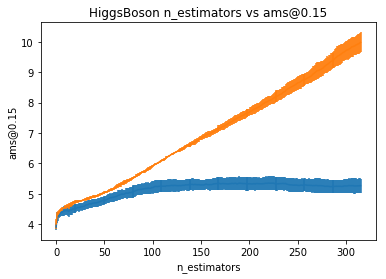

In [21]:
n_estimators = cvresult.shape[0]

from matplotlib import pyplot
# plot
test_means = cvresult['test-ams@0.15-mean']
test_stds = cvresult['test-ams@0.15-std'] 
        
train_means = cvresult['train-ams@0.15-mean']
train_stds = cvresult['train-ams@0.15-std'] 

x_axis = range(0, n_estimators)
pyplot.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')
pyplot.errorbar(x_axis, train_means, yerr=train_stds ,label='Train')
pyplot.title("HiggsBoson n_estimators vs ams@0.15")
pyplot.xlabel( 'n_estimators' )
pyplot.ylabel( 'ams@0.15' )
pyplot.savefig( 'HiggsBoson_estimators.png' )
pyplot.show()

In [22]:
#Fit the algorithm on the data, cv 函数没有refit步骤
#alg.fit(X_train, y_train, eval_metric='ams@0.15')
print ('train model using the best parameters by cv ... ')
bst = xgb.train( param, dtrain, n_estimators );

In [23]:
# save out model
bst.save_model('higgs_cv.model')

print ('train finished')

train finished


### 测试过程（higgs-pred.py）

In [24]:
#!/usr/bin/python
# make prediction
import numpy as np
import xgboost as xgb


#### 读取测试数据和训练好的模型

In [25]:
# path to where the data lies
dpath = './data/'

modelfile = 'higgs_cv.model'
outfile = 'higgs.pred.csv'
# make top 15% as positive
threshold_ratio = 0.15

# load in test, directly use numpy
dtest = np.loadtxt( dpath+'/higgsboson_test.csv', delimiter=',', skiprows=1 )
data   = dtest[:,1:31]
idx = dtest[:,0]

print ('finish loading from csv ')


finish loading from csv 


#### XGBoost测试环境准备

测试数据导入DMatrix
模型导入

In [26]:
xgmat = xgb.DMatrix( data, missing = -999.0 )
bst = xgb.Booster({'nthread':8}, model_file = modelfile)


#### 测试

In [27]:
ypred = bst.predict( xgmat )


#### 测试结果整理，写入结果提交文件

In [28]:
res  = [ ( int(idx[i]), ypred[i] ) for i in range(len(ypred)) ]

rorder = {}
for k, v in sorted( res, key = lambda x:-x[1] ):
    rorder[ k ] = len(rorder) + 1

# write out predictions
ntop = int( threshold_ratio * len(rorder ) )
fo = open(outfile, 'w')
nhit = 0
ntot = 0
fo.write('EventId,RankOrder,Class\n')
for k, v in res:
    if rorder[k] <= ntop:
        lb = 's'
        nhit += 1
    else:
        lb = 'b'
    # change output rank order to follow Kaggle convention
    fo.write('%s,%d,%s\n' % ( k,  len(rorder)+1-rorder[k], lb ) )
    ntot += 1
fo.close()

print ('finished writing into prediction file')

finished writing into prediction file
